In [2]:
%pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [5]:
mp_face_detection = mp.solutions.face_detection

face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

mp_drawing = mp.solutions.drawing_utils

(-0.5, 1473.5, 1348.5, -0.5)

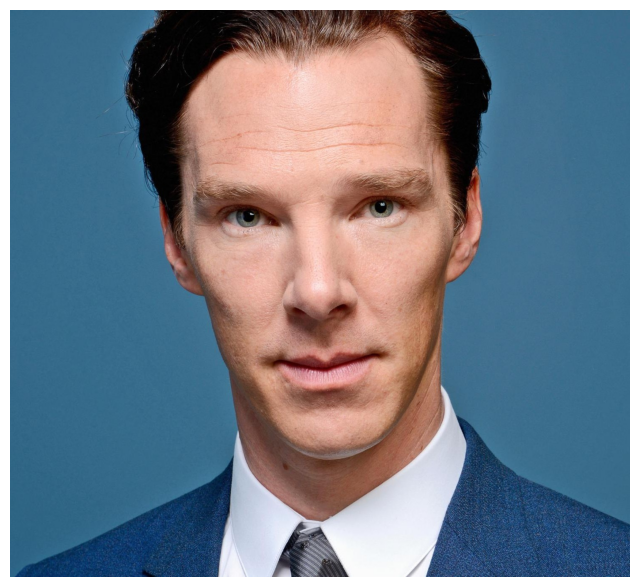

In [6]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("./man.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')

Face number:  0
Face score: 91.68 %

Bounding box:  xmin: 0.23862531781196594
ymin: 0.1676047146320343
width: 0.5461864471435547
height: 0.5967429876327515

Key points: 
x: 0.3796302080154419
y: 0.3662802577018738

x: 0.5976762175559998
y: 0.3510705828666687

x: 0.48377397656440735
y: 0.5278100371360779

x: 0.49995988607406616
y: 0.6284639835357666

x: 0.293592631816864
y: 0.3955235481262207

x: 0.7371786832809448
y: 0.36199402809143066



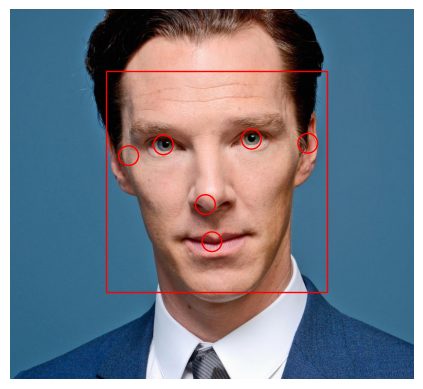

In [7]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.imshow(img)
ax.set_axis_off()

width = 1473.5
height = 1348.5

face_detection_results = face_detection.process(img[:, :, ::-1])

if face_detection_results.detections:
    for face_no, face in enumerate(face_detection_results.detections):
        print("Face number: ", face.label_id[0])
        print("Face score: {:.2f} %".format(face.score[0]*100))

        face_data = face.location_data

        print("\nBounding box: ", face_data.relative_bounding_box)
        bbox = face_data.relative_bounding_box
        bounding_box_rect = patches.Rectangle((bbox.xmin*width, bbox.ymin*height), bbox.width*width, bbox.height*height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(bounding_box_rect)

        print("Key points: ")
        for point in face_data.relative_keypoints:
            print(point)
            
        ax.scatter([point.x*width for point in face_data.relative_keypoints], [point.y*height for point in face_data.relative_keypoints], facecolors='none', edgecolors='r', s=200)



In [8]:
mp_face_mesh = mp.solutions.face_mesh

face_mesh_images = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=3, min_detection_confidence=0.3)

face_mesh_videos = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=3, min_detection_confidence=0.5, min_tracking_confidence=0.3)

mp_drawing_styles = mp.solutions.drawing_styles

In [9]:
import numpy as np
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

def detect_facial_landmarks(rgb_image, face_detection, display=False, line_thickness=1):
  detection_result = face_detection.process(rgb_image)

  face_landmarks_list = detection_result.multi_face_landmarks
  annotated_image = np.copy(rgb_image)

  if detection_result.multi_face_landmarks:
    # Loop through the detected faces to visualize.
    for face_landmarks in face_landmarks_list:
      tesselation_style = mp_drawing_styles.get_default_face_mesh_tesselation_style()
      tesselation_style.thickness = line_thickness

      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_TESSELATION,
          landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=line_thickness),
          connection_drawing_spec=tesselation_style)
      
      contours_styles = mp_drawing_styles.get_default_face_mesh_contours_style()
      for style in contours_styles:
          contours_styles[style].thickness = line_thickness

      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_CONTOURS,
          landmark_drawing_spec=None,
          connection_drawing_spec=contours_styles)
    
  if display:
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    axs[0].imshow(rgb_image)
    axs[0].set_axis_off()
    axs[0].set_title("Original")
    axs[1].imshow(annotated_image)
    axs[1].set_axis_off()
    axs[1].set_title("With Mesh")
  else:
    return np.ascontiguousarray(annotated_image, dtype=np.uint8) #, np.array([[[point.x, point.y, point.z] for point in multi_face_landmarks.landmark] for multi_face_landmarks in face_landmarks_list])


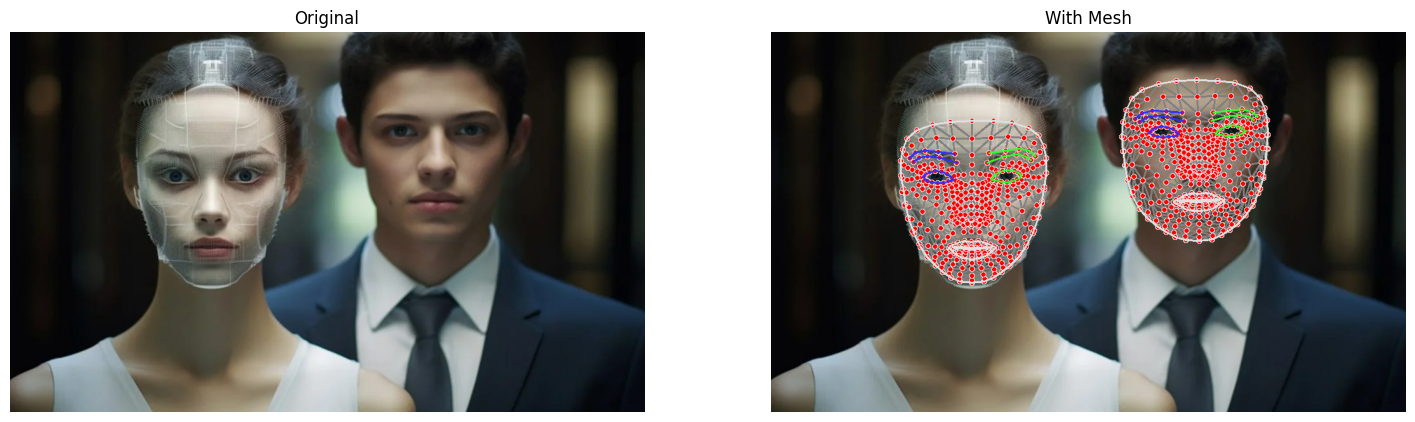

In [10]:
img2 = cv2.imread("./people2.webp")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

detect_facial_landmarks(img2, face_mesh_images, True, line_thickness=2)


In [15]:
from time import time

camera_video = cv2.VideoCapture(0)
camera_video.set(3, 1280)
camera_video.set(4, 960)

cv2.namedWindow('Face landmarks Detection', cv2.WINDOW_NORMAL)

time1 = 0

while camera_video.isOpened():
    ok, frame = camera_video.read()

    if not ok:
        continue

    frame = cv2.flip(frame, 1)
    frame = detect_facial_landmarks(frame, face_mesh_videos, False, line_thickness=2)

    time2 = time()

    if time2 - time1 > 0:

        frames_per_second = 1.0 / (time2 - time1)
        
        cv2.putText(frame, f'FPS: {int(frames_per_second)}', (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)

        time1 = time2

        cv2.imshow('Face landmarks Detection', frame)
        k = cv2.waitKey(1) & 0xFF

        if k == 27:
            break

camera_video.release()
cv2.destroyAllWindows()